<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part6/P6_Ch03_CH01_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLU 시스템 구성
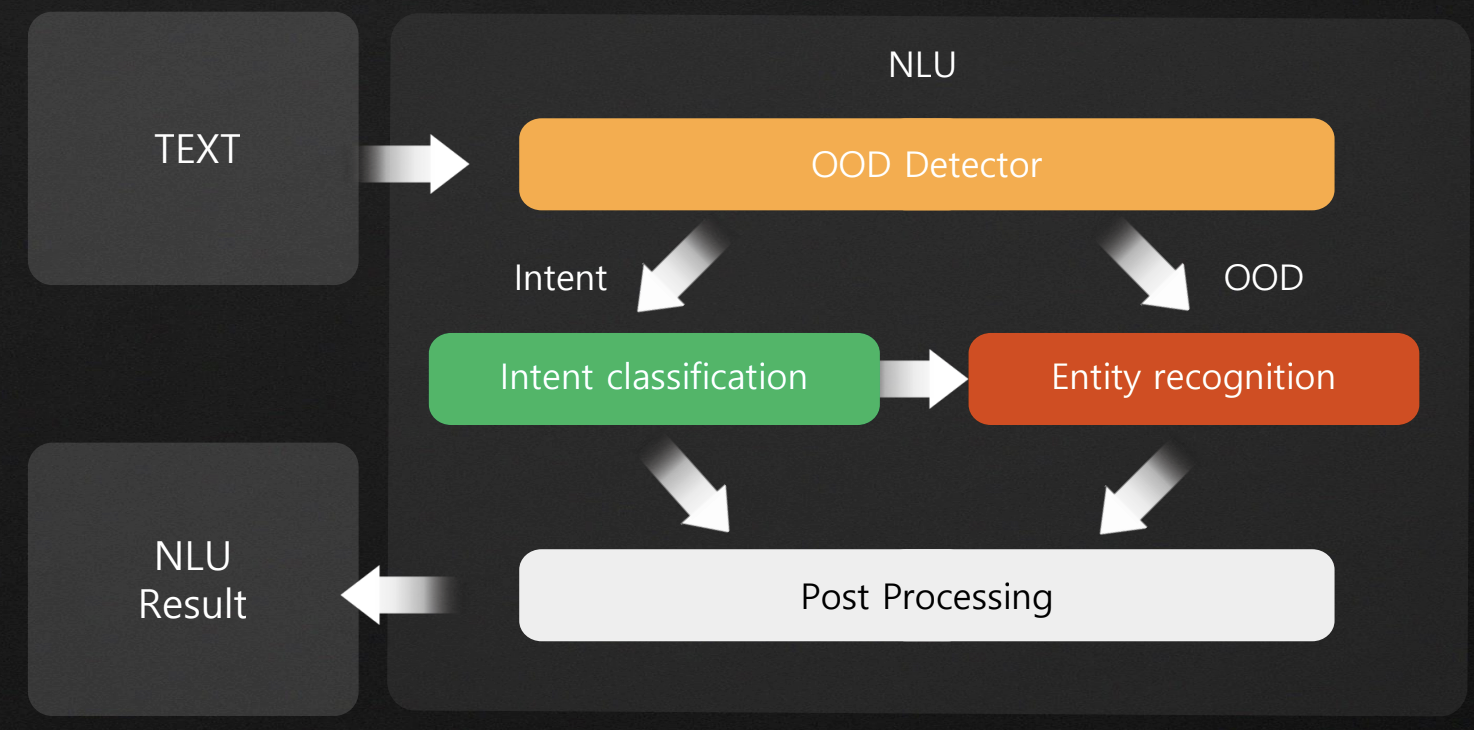

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install sentencepiece
!pip uninstall pytorch-crf
!pip install pytorch-crf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.4 MB/s eta 0:00:00


In [3]:
import os
import sys
import json
import torch
import random

%cd /content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇
from src.model import BiLSTM_CRF, MakeEmbed, textCNN, DAN, EpochLogger, save
from src.dataset import Preprocessing, MakeDataset
%cd /root

/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇
/root


In [4]:
class NaturalLanguageUnderstanding:

    def __init__(self):
        self.dataset = MakeDataset()
        self.embed = MakeEmbed()
        self.embed.load_word2vec()

        self.weights = self.embed.word2vec.wv.vectors
        self.weights = torch.FloatTensor(self.weights)

        self.intent_clsf = textCNN(self.weights, 256, [3,4,5], 0.5, len(self.dataset.intent_label))
        self.slot_tagger = BiLSTM_CRF(self.weights, self.dataset.entity_label, 256, 128)
        self.ood_detector = DAN(self.weights, 256, 0.5, 2)

    def init_NLU_result(self): # NLU 결과
        NLU_result = {
                    "INTENT" : "",
                    "SLOT"   :[

                        ]
                    }
        return NLU_result

    def model_load(self, intent_path, slot_path, ood_path):
        self.intent_clsf.load_state_dict(torch.load(intent_path))
        self.slot_tagger.load_state_dict(torch.load(slot_path))
        self.ood_detector.load_state_dict(torch.load(ood_path))
        self.intent_clsf.eval()
        self.slot_tagger.eval()
        self.ood_detector.eval()

    def predict(self, query):
        x = self.dataset.prep.pad_idx_sequencing(self.embed.query2idx(self.dataset.tokenize(query)))

        x = torch.tensor(x)
        '''
        ood dectector
        '''
        f = self.ood_detector(x.unsqueeze(0))
        ood = torch.argmax(f).tolist()
        print(ood)
        if(ood): # ood가 아니라면 -> intent classification
            '''
            intent clsf
            '''
            f = self.intent_clsf(x.unsqueeze(0))

            intent = self.dataset.intents[torch.argmax(f).tolist()]
        else:
            intent = "ood"

        '''
        slot tagger
        '''
        f = self.slot_tagger(x.unsqueeze(0)) # 해당 슬롯이 무엇인지 추출

        mask = torch.where(x > 0, torch.tensor([1.]), torch.tensor([0.])).type(torch.uint8)

        predict = self.slot_tagger.decode(f,mask.view(1,-1)) # 마스킹 후 디코딩하여 슬롯 예측
        return intent, predict

    def convert_nlu_result(self, query, intent, predict):
        NLU_result = self.init_NLU_result()
        x_token =query.split()

        # slot 태깅된 token 후처리
        '''
        q : 제주도 맛집
        NLU.nlu_predict : ['restaurant', [[12, 0]]]
                                            [12, 0] = [S-LOCATION, O]

        '''
        slots = [] # 후처리된 SLOT들 저장
        BIE = []   # 후처리가 필요한 SLOT모아두기
        prev = ""; # 이전 슬롯이 무엇인지 저장
        for i, slot in enumerate([self.dataset.entitys[p] for p in predict[0]]):
            name = slot[2:]

            if("S-" in slot):
                if(BIE != []):
                    '''
                    B-LOCATION, I-LOCATION, S-DATE 인 경우
                    S-DATE 이전에 BIE에 담긴 B-LOCATION, I-LOCATION 들을 저장
                    '''
                    slots.append(prev[2:] +"^"+" ".join(BIE))
                    BIE = []
                slots.append(name+"^"+x_token[i])
            elif("B-" in slot):
                '''
                뒤에 합쳐야하는 SLOT이 등장할 예정이므로 BIE에 저장
                '''
                BIE.append(x_token[i])
                prev = slot
            elif("I-" in slot and "B" in prev):
                '''
                뒤에 합쳐야하는 SLOT이 등장할 예정이므로 BIE에 저장
                '''
                BIE.append(x_token[i])
                prev = slot
            elif("E-" in slot and ("I" in prev or "B" in prev)):
                '''
                SLOT의 끝에 도달했으므로
                BIE에 저장된 TOKEN을 SLOTS으로 JOIN하여 저장
                '''
                BIE.append(x_token[i])
                slots.append(name+"^"+" ".join(BIE))
                BIE = []
            else:
                '''
                O인 경우 BIE가 있으면 저장
                '''
                if(BIE != []):
                    slots.append(prev[2:]+"^"+" ".join(BIE))
                    BIE = []
        NLU_result["INTENT"] = intent
        NLU_result["SLOT"]   = slots
        return NLU_result

    def run(self, query):
        intent, predict = self.predict(query)
        self.nlu_predict = [intent, predict]
        NLU_result = self.convert_nlu_result(query, intent, predict)
        return NLU_result

    def print_nlu_result(self, nlu_result):
        print('발화 의도 : ' + nlu_result.get('INTENT'))
        print('발화 개체 : ')
        for slot_concat in nlu_result.get('SLOT'):
            slot_name = slot_concat.split('^')[0]
            slot_value = slot_concat.split('^')[1]
            print("    "+slot_name + " : " + slot_value)

In [5]:
intent_pretrain_path = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/save/1_intent_clsf_model/intent_clsf_97.217_steps_33.pt"
entity_pretrain_path = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/save/1_entity_recog_model/entity_recog_97.192_steps_7.pt"
ood_pretrain_path = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/save/1_ood_clsf_model/ood_clsf_99.724_steps_5.pt"

In [6]:
NLU = NaturalLanguageUnderstanding()

NLU.model_load(intent_pretrain_path, entity_pretrain_path, ood_pretrain_path)

In [7]:
NLU_result = NLU.run("제주도 맛집")

NLU.print_nlu_result(NLU_result)

1
발화 의도 : restaurant
발화 개체 : 
    LOCATION : 제주도


/usr/local/lib/python3.10/dist-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:493.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


In [8]:
NLU_result = NLU.run("오늘 제주도 날씨")

NLU.print_nlu_result(NLU_result)

1
발화 의도 : weather
발화 개체 : 
    DATE : 오늘
    LOCATION : 제주도


In [9]:
NLU_result = NLU.run("제주도")

NLU.print_nlu_result(NLU_result)

0
발화 의도 : ood
발화 개체 : 
    LOCATION : 제주도


In [10]:
NLU_result = NLU.run("나 내일 제주도 여행가는데 미세먼지 알려줘")

NLU.print_nlu_result(NLU_result)

1
발화 의도 : dust
발화 개체 : 
    DATE : 내일
    LOCATION : 제주도


In [11]:
NLU_result = NLU.run("나 이번 주 제주도 여행가는데 미세먼지 알려줘")

NLU.print_nlu_result(NLU_result)

1
발화 의도 : dust
발화 개체 : 
    DATE : 이번 주
    LOCATION : 제주도


In [12]:
NLU.nlu_predict

['dust', [[0, 1, 5, 12, 0, 0, 0]]]